In [45]:
#importamos bibliotecas
import os
import re
import csv
import pandas as pd
import random
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [23]:
#--------------- CSV DATASETS ---------------

In [2]:
#Creamos dataset.csv partiendo de las imágenes que componen nuestro dataset

In [3]:
# Ruta del directorio principal del dataset
dataset_dir = r'D:\Feina\00_Test'

# Crear un archivo CSV para almacenar la información
csv_path = os.path.join(dataset_dir, 'dataset.csv')
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'patient', 'case', 'order'])

    # Recorrer las carpetas de pacientes de MCH
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'MCH')):
        # Obtener el número de paciente a partir del nombre de la carpeta
        patient_num = os.path.basename(root).replace('_', '')

        # Ordenar los archivos por número
        sorted_files = sorted([f for f in files if f.endswith('.png') and not f.startswith('seg.')],
                              key=lambda x: int(re.findall(r'\d+', x)[0]))

        # Recorrer los archivos en la carpeta de imágenes en orden
        for i, file in enumerate(sorted_files):
            # Crear una fila con la información del archivo y el orden
            row = [os.path.join(root, file), patient_num, 0, i]
            writer.writerow(row)

    # Recorrer las carpetas de pacientes de NO_MCH
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'NO_MCH')):
        # Obtener el número de paciente a partir del nombre de la carpeta
        patient_num = os.path.basename(root).replace('_', '')

        # Ordenar los archivos por número
        sorted_files = sorted([f for f in files if f.endswith('.png') and not f.startswith('seg.')],
                              key=lambda x: int(re.findall(r'\d+', x)[0]))

        # Recorrer los archivos en la carpeta de imágenes en orden
        for i, file in enumerate(sorted_files):
            # Crear una fila con la información del archivo y el orden
            row = [os.path.join(root, file), patient_num, 1, i]
            writer.writerow(row)

In [4]:
#Creamos dataset_structure.txt en el que se explica las columnas de dataset.csv

In [5]:
# Ruta del directorio principal del dataset
dataset_dir = r'D:\Feina\00_Test'

# Ruta del archivo CSV
csv_path = os.path.join(dataset_dir, 'dataset.csv')

# Ruta del archivo de texto
txt_path = os.path.join(dataset_dir, 'dataset_structure.txt')

# Abrir el archivo de texto en modo de escritura
with open(txt_path, 'w') as f:
    # Escribir la explicación de la estructura del archivo CSV
    f.write('El archivo CSV contiene la siguiente estructura de columnas:\n\n')
    f.write('image: la ruta de la imagen\n')
    f.write('patient: el número de paciente (cogerlo del nombre de la carpeta sin "_")\n')
    f.write('case: 0 o 1. 0 si MCH, 1 si no MCH\n')
    f.write('order: el orden de las imágenes en la carpeta, en función del nombre de la imagen siguiendo una lógica humana\n')

    # Escribir una línea en blanco
    f.write('\n')

    # Escribir la ruta del archivo CSV
    f.write('El archivo CSV se encuentra en la siguiente ruta:\n\n')
    f.write(csv_path)

In [6]:
#Miramos la cantidad de imágenes de cada paciente para regular los lotes

In [12]:
path = r"D:\Feina\00_Test\dataset.csv"
df = pd.read_csv(path)

print(df.head())

                                     image  patient  case  order
0  D:\Feina\00_Test\MCH\_10\Mag (0024).png       10     0      0
1  D:\Feina\00_Test\MCH\_10\Mag (0048).png       10     0      1
2  D:\Feina\00_Test\MCH\_10\Mag (0072).png       10     0      2
3  D:\Feina\00_Test\MCH\_10\Mag (0096).png       10     0      3
4  D:\Feina\00_Test\MCH\_10\Mag (0120).png       10     0      4


In [17]:
path = r"D:\Feina\00_Test\dataset.csv"
df = pd.read_csv(path)

images_per_patient = df.groupby('patient')['image'].count()
max_images = images_per_patient.max()
min_images = images_per_patient.min()

max_patients = images_per_patient[images_per_patient == max_images].index.to_list()
min_patients = images_per_patient[images_per_patient == min_images].index.to_list()

print("Número máximo de imágenes por paciente:", max_images)
print("Número mínimo de imágenes por paciente:", min_images)
print("\nPacientes con el número máximo de imágenes:", ", ".join(map(str, max_patients)))
print("Pacientes con el número mínimo de imágenes:", ", ".join(map(str, min_patients)))

Número máximo de imágenes por paciente: 15
Número mínimo de imágenes por paciente: 10

Pacientes con el número máximo de imágenes: 4, 6, 7, 121, 276
Pacientes con el número mínimo de imágenes: 114, 115, 278, 283, 284, 285


In [8]:
#Equilibramos los lotes

In [9]:
# Leer el archivo CSV
df = pd.read_csv(r'D:\Feina\00_Test\dataset.csv')

# Convertir la columna 'order' en tipo numérico
df['order'] = pd.to_numeric(df['order'], errors='coerce')

# Agrupar por paciente
grouped = df.groupby('patient')

# Crear una lista para guardar los dataframes modificados
modified_dfs = []

# Iterar por cada grupo de pacientes
for name, group in grouped:
    # Si el grupo tiene más de 12 filas, eliminar las filas extra
    if len(group) > 12:
        group = group.sort_values(by='order').iloc[-12:]
    # Si el grupo tiene menos de 12 filas, duplicar las filas hasta llegar a 12
    elif len(group) < 12:
        num_repeats = int(12 / len(group)) + 1
        group = pd.concat([group] * num_repeats, ignore_index=True)
        group = group.iloc[:12]
    # Actualizar la columna 'order'
    group['order'] = group['order'] - group['order'].min()
    # Agregar el dataframe modificado a la lista
    modified_dfs.append(group)

# Concatenar todos los dataframes modificados
modified_df = pd.concat(modified_dfs)

# Guardar el archivo modificado como CSV
modified_df.to_csv(r'D:\Feina\00_Test\modified_dataset.csv', index=False)

In [10]:
#Miramos si ahora hay la misma cantidad de imágenes

In [14]:
path = r"D:\Feina\00_Test\modified_dataset.csv"
df = pd.read_csv(path)

images_per_patient = df.groupby('patient')['image'].count()
max_images = images_per_patient.max()
min_images = images_per_patient.min()

print("Número máximo de imágenes por paciente:", max_images)
print("Número mínimo de imágenes por paciente:", min_images)

Número máximo de imágenes por paciente: 12
Número mínimo de imágenes por paciente: 12


In [44]:
#Creamos datasets de entrenamiento y testing

In [19]:
# Ruta del archivo CSV
csv_path = r'D:\Feina\00_Test\modified_dataset.csv'

# Porcentaje de pacientes para train
train_percentage = 0.8

# Leer el archivo CSV
with open(csv_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)

    # Crear una lista para almacenar las filas del archivo CSV
    rows = []

    # Recorrer las filas del archivo CSV y guardarlas en la lista
    for row in reader:
        rows.append(row)

# Obtener la lista de pacientes únicos en el dataset
patients = list(set(row['patient'] for row in rows))

# Barajar aleatoriamente la lista de pacientes
random.shuffle(patients)

# Calcular el número de pacientes para train y test
num_train = int(len(patients) * train_percentage)
num_test = len(patients) - num_train

# Dividir la lista de pacientes en dos listas: una para train y otra para test
train_patients = patients[:num_train]
test_patients = patients[num_train:]

# Filtrar las filas del dataset para separar las correspondientes a los pacientes de train y test
train_rows = [row for row in rows if row['patient'] in train_patients]
test_rows = [row for row in rows if row['patient'] in test_patients]

# Escribir las listas de filas de train y test en los archivos correspondientes
train_csv_path = r'D:\Feina\00_Test\train.csv'
with open(train_csv_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=reader.fieldnames)
    writer.writeheader()
    writer.writerows(train_rows)

test_csv_path = r'D:\Feina\00_Test\test.csv'
with open(test_csv_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=reader.fieldnames)
    writer.writeheader()
    writer.writerows(test_rows)

In [22]:
#--------------- IMAGE AUGMENTATION ---------------

In [14]:
# Cargar el archivo CSV que contiene la información de las imágenes
path = r"D:\Feina\00_Test\modified_dataset.csv"
df = pd.read_csv(path)

# Cargar el archivo CSV que contiene la información de entrenamiento
train_df = pd.read_csv(r"D:\Feina\00_Test\train.csv")

# Crear un diccionario de transformaciones personalizadas por paciente
augmentations = {}

# Iterar sobre los números de paciente únicos en el conjunto de entrenamiento
for patient_id in train_df['patient'].unique():
    
    # Generar valores fijos para la rotación, traslación y escalado
    fixed_rotation = np.random.uniform(-10, 10)
    fixed_translation_x = np.random.uniform(-0.2, 0.2)
    fixed_translation_y = np.random.uniform(-0.2, 0.2)
    fixed_scale_x = np.random.uniform(0.8, 1.2)
    fixed_scale_y = np.random.uniform(0.8, 1.2)

    # Crear una transformación imgaug secuencial para cada paciente con valores fijos
    transformation = iaa.Sequential([
        iaa.Affine(rotate=fixed_rotation),
        iaa.Affine(translate_percent={"x": fixed_translation_x, "y": fixed_translation_y}),
        iaa.Affine(scale={"x": fixed_scale_x, "y": fixed_scale_y})
    ])
    
    # Agregar la transformación al diccionario, con el número de paciente como clave
    augmentations[patient_id] = transformation

In [16]:
# Agregar la transformación al diccionario, con el número de paciente como clave
augmentations[patient_id] = transformation

# Iterar sobre las filas del archivo CSV que contiene la información de las imágenes
current_transformation = None  # Inicializar la transformación actual como nula
for index, row in df.iterrows():
    img_path = row['image']  # Ruta de la imagen
    patient_id = row['patient']  # Número de paciente
    
    # Si el número de paciente no está en el conjunto de entrenamiento, saltar a la siguiente imagen
    if patient_id not in train_df['patient'].values:
        continue
    
    # Cargar la imagen
    img = cv2.imread(img_path)
    
    # Crear la transformación correspondiente al paciente si está disponible
    if patient_id in augmentations:
        # Si la transformación actual no coincide con la del paciente actual, actualizarla
        if augmentations[patient_id] != current_transformation:
            current_transformation = augmentations[patient_id]
        
        # Aplicar la transformación correspondiente al paciente a la imagen actual
        aug_img = current_transformation(image=img)
    else:
        aug_img = img
    
    # Crear la ruta de destino de la carpeta y guardar la imagen aumentada
    img_folder, img_name = os.path.split(img_path)
    parent_folder, patient_folder = os.path.split(img_folder)
    new_patient_folder = "_9999" + str(patient_folder).split("_")[1]  # Agregar el prefijo "_9999" al número de paciente original
    dest_folder = os.path.join(parent_folder, new_patient_folder)
    
    os.makedirs(dest_folder, exist_ok=True)
    new_img_path = os.path.join(dest_folder, img_name.replace(".png", "_aug.png"))
    cv2.imwrite(new_img_path, aug_img)

In [10]:
# Cargar el archivo CSV que contiene la información de las imágenes
path = r"D:\Feina\00_Test\modified_dataset.csv"
df = pd.read_csv(path)

# Cargar el archivo CSV que contiene la información de entrenamiento
train_df = pd.read_csv(r"D:\Feina\00_Test\train.csv")

# Crear un diccionario de transformaciones personalizadas por paciente
augmentations = {}

# Iterar sobre los números de paciente únicos en el conjunto de entrenamiento
for patient_id in train_df['patient'].unique():
    
    # Crear una transformación imgaug secuencial para cada paciente
    transformation = iaa.Sequential([
        iaa.Affine(rotate=(-10, 10)),  # Rotación en grados
        iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Traslación en porcentaje de la imagen
        iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})  # Escalado en porcentaje de la imagen
    ])
    
    # Agregar la transformación al diccionario, con el número de paciente como clave
    augmentations[patient_id] = transformation

# Iterar sobre las filas del archivo CSV que contiene la información de las imágenes
for index, row in df.iterrows():
    img_path = row['image']  # Ruta de la imagen
    patient_id = row['patient']  # Número de paciente
    
    # Si el número de paciente no está en el conjunto de entrenamiento, saltar a la siguiente imagen
    if patient_id not in train_df['patient'].values:
        continue
    
    # Cargar la imagen
    img = cv2.imread(img_path)
    
    # Aplicar la transformación correspondiente al paciente a la imagen actual
    if patient_id in augmentations:
        aug_img = augmentations[patient_id](image=img)
    else:
        aug_img = img
    
    # Crear la ruta de destino de la carpeta y guardar la imagen aumentada
    img_folder, img_name = os.path.split(img_path)
    parent_folder, patient_folder = os.path.split(img_folder)
    new_patient_folder = "_9999" + str(patient_folder).split("_")[1]  # Agregar el prefijo "_9999" al número de paciente original
    dest_folder = os.path.join(parent_folder, new_patient_folder)
    
    os.makedirs(dest_folder, exist_ok=True)
    new_img_path = os.path.join(dest_folder, img_name.replace(".png", "_aug.png"))
    cv2.imwrite(new_img_path, aug_img)

In [33]:
#Actualizamos train.csv

In [19]:
data_dir = r"D:\Feina\00_Test"
out_file = r"D:\Feina\00_Test\train_aug.csv"

rows = []
for case in ["MCH", "NO_MCH"]:
    case_dir = os.path.join(data_dir, case)
    for patient_folder in os.listdir(case_dir):
        if patient_folder.startswith("_9999"):
            patient_num = patient_folder[1:]
            patient_path = os.path.join(case_dir, patient_folder)
            for i, img_name in enumerate(sorted(os.listdir(patient_path))):
                if img_name.endswith(".png"):
                    img_path = os.path.join(patient_path, img_name)
                    rows.append([img_path, patient_num, int(case == "NO_MCH"), i])

with open(out_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "patient", "case", "order"])
    writer.writerows(rows)

In [20]:
train_file = r"D:\Feina\00_Test\train.csv"
train_aug_file = r"D:\Feina\00_Test\train_aug.csv"
out_file = r"D:\Feina\00_Test\train_full.csv"

with open(train_file, "r") as f:
    reader = csv.reader(f)
    headers = next(reader)
    data = [row for row in reader]

with open(train_aug_file, "r") as f:
    reader = csv.reader(f)
    next(reader)  # Descartar la fila de encabezado
    for row in reader:
        data.append(row)

with open(out_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(data)

In [21]:
# ------------------ TRANSFER LEARNING Y ENTRENAMIENTO --------------------

In [29]:
# Cargar los archivos CSV
train_data = pd.read_csv(r'D:\Feina\00_Test\train_full.csv')
test_data = pd.read_csv(r'D:\Feina\00_Test\test.csv')

In [33]:
# Cargar el modelo VGG16 con pesos pre-entrenados de ImageNet, sin la última capa de clasificación
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [35]:
def custom_image_generator(data, batch_size, target_size=(224, 224)):
    i = 0
    while True:
        batch = {'images': [], 'labels': []}
        for b in range(batch_size):
            if i == len(data):
                i = 0
            row = data.iloc[i]
            img_path, label = row['image'], row['case']
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            batch['images'].append(img)
            batch['labels'].append(label)
            i += 1
        batch['images'] = np.array(batch['images'])
        batch['labels'] = np.array(batch['labels'])
        yield batch['images'], batch['labels']

In [36]:
batch_size = 36

train_generator = custom_image_generator(train_data, batch_size=batch_size)
test_generator = custom_image_generator(test_data, batch_size=batch_size)

In [37]:
# Añadir capas personalizadas al modelo VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [39]:
# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# Entrenar el modelo
model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=50)

# Evaluar el rendimiento en el conjunto de prueba
scores = model.evaluate_generator(test_generator, steps=len(test_data) // batch_size)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

Epoch 1/50


C:\Users\Marc\AppData\Local\Temp\ipykernel_1452\3504607629.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


23/23 [==============================] - 45s 2s/step - loss: 0.7146 - accuracy: 0.6763
Epoch 2/50
23/23 [==============================] - 42s 2s/step - loss: 0.6715 - accuracy: 0.6715
Epoch 3/50
23/23 [==============================] - 44s 2s/step - loss: 0.6963 - accuracy: 0.6546
Epoch 4/50
23/23 [==============================] - 45s 2s/step - loss: 0.6952 - accuracy: 0.6618
Epoch 5/50
23/23 [==============================] - 44s 2s/step - loss: 0.6442 - accuracy: 0.6884
Epoch 6/50
23/23 [==============================] - 44s 2s/step - loss: 0.6170 - accuracy: 0.7126
Epoch 7/50
23/23 [==============================] - 43s 2s/step - loss: 0.6047 - accuracy: 0.7222
Epoch 8/50
23/23 [==============================] - 43s 2s/step - loss: 0.6260 - accuracy: 0.7029
Epoch 9/50
23/23 [==============================] - 46s 2s/step - loss: 0.5915 - accuracy: 0.7005
Epoch 10/50
23/23 [==============================] - 42s 2s/step - loss: 0.5888 - accuracy: 0.7053
Epoch 11/50
23/23 [===========

C:\Users\Marc\AppData\Local\Temp\ipykernel_1452\3504607629.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, steps=len(test_data) // batch_size)


Test loss: 0.8054949641227722
Test accuracy: 0.6111111044883728


In [43]:
# Guardar el modelo entrenado en un archivo en otro directorio
model.save(r'D:\Feina\00_Test\vgg16_model.h5')

In [46]:
#-------- GRADCAM ------------#

In [65]:
def grad_cam(model, image_path, layer_name):
    # Cargar y preprocesar la imagen
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Especificar la capa convolucional de interés en el modelo VGG16
    conv_layer = model.get_layer(layer_name)

    # Crear un nuevo modelo que incluya la capa convolucional de interés y la capa de salida
    conv_model = tf.keras.Model(model.inputs, [conv_layer.output, model.output])

    # Calcular la salida de la capa convolucional y la clase predicha
    with tf.GradientTape() as tape:
        conv_output, preds = conv_model(x)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]

    # Calcular los gradientes de la clase objetivo con respecto a la capa deseada
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2), keepdims=True)

    # Multiplicar los mapas de activación por los gradientes ponderados
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Reajustar los valores entre 0 y 1 y redimensionar el mapa de calor
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam[0], (224, 224))

    # Convertir el mapa de calor a RGB
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Superponer la imagen original y el mapa de calor
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    superimposed_img = np.uint8(heatmap * 0.4 + img)

    # Mostrar la imagen original, el mapa de calor y la imagen superpuesta
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Imagen original')
    ax[1].imshow(heatmap)
    ax[1].axis('off')
    ax[1].set_title('Mapa de calor')
    ax[2].imshow(superimposed_img)
    ax[2].axis('off')
    ax[2].set_title('Imagen superpuesta')
    plt.show()




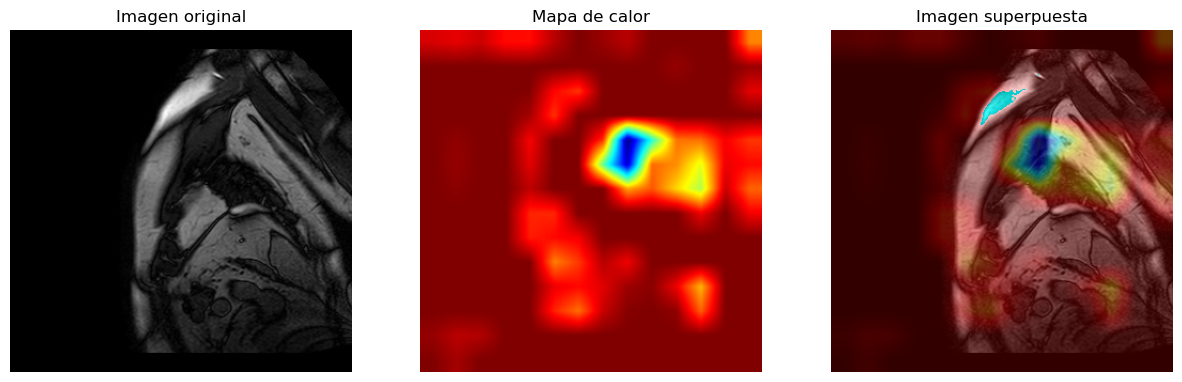

In [66]:
# Especificar la ruta de la imagen y la capa convolucional de interés
image_path = r'D:\Feina\00_Test\MCH\_14\Mag (0024).png'
layer_name = 'block5_conv3'  # Elige la capa convolucional de interés en el modelo VGG16

# Aplicar la función grad_cam para visualizar el mapa Grad-CAM
grad_cam(model, image_path, layer_name)




Procesando imagen 1...


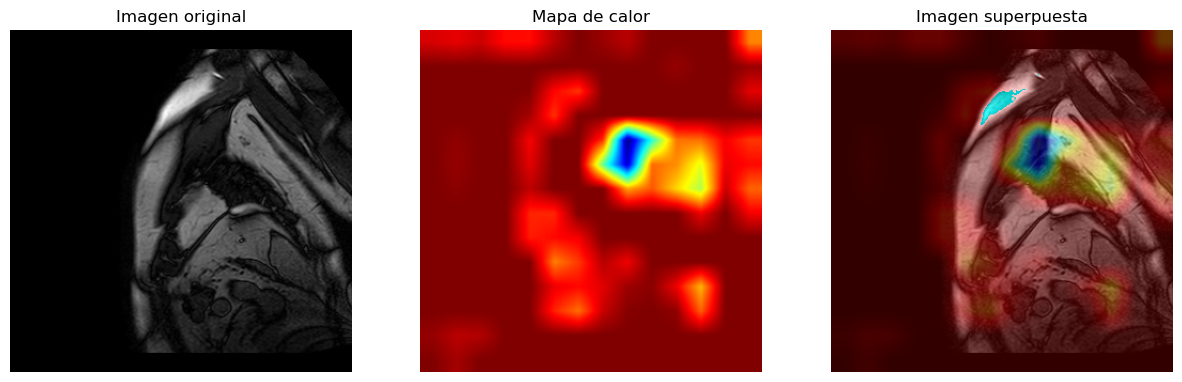

Procesando imagen 2...


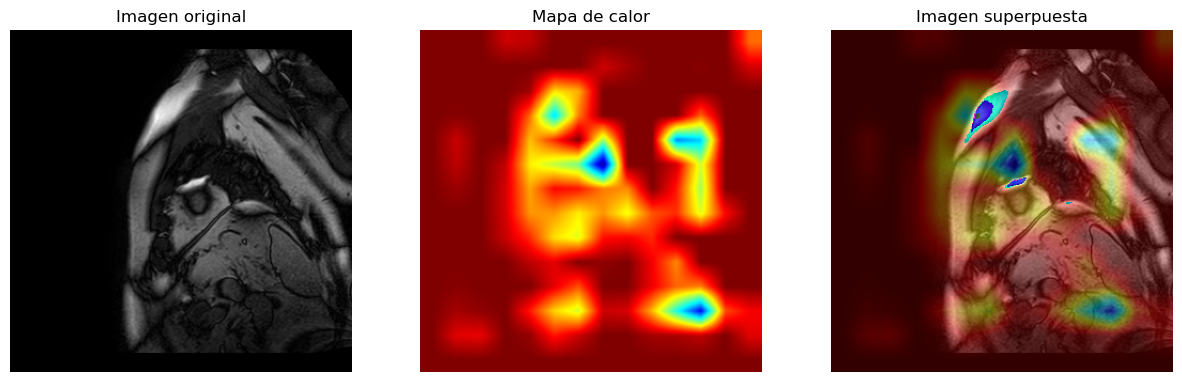

Procesando imagen 3...


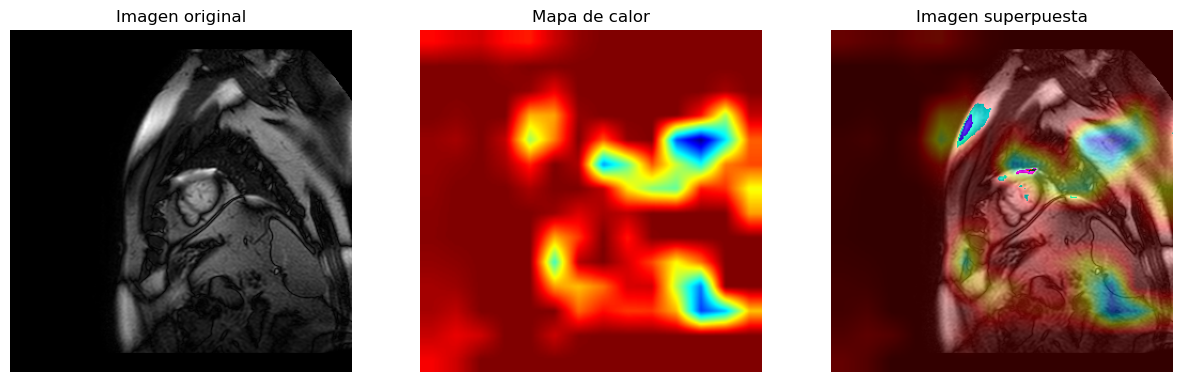

Procesando imagen 4...


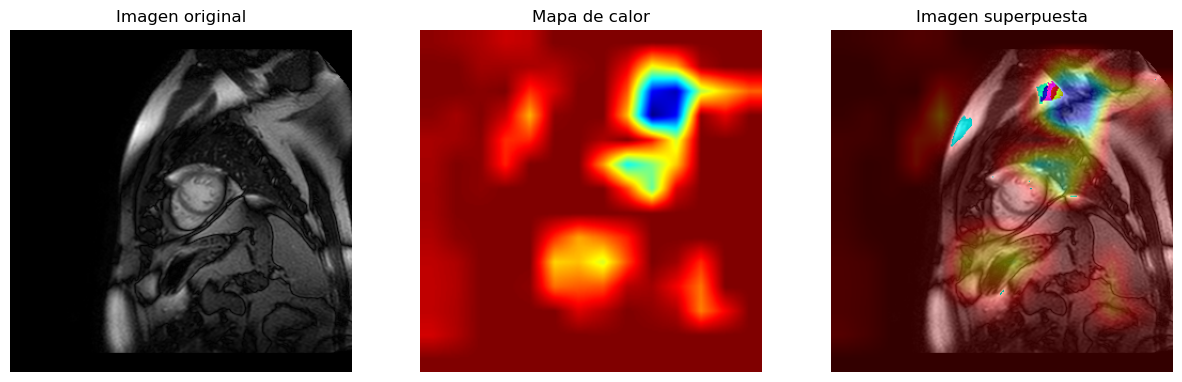

Procesando imagen 5...


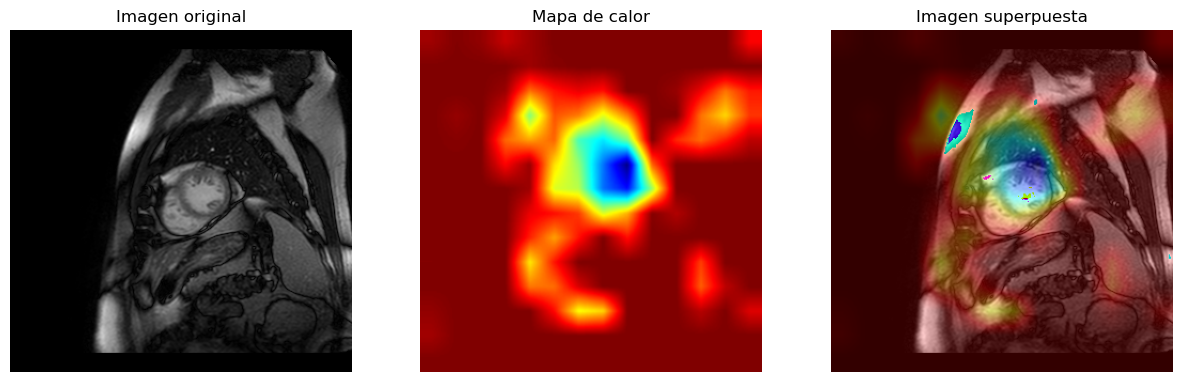

Procesando imagen 6...


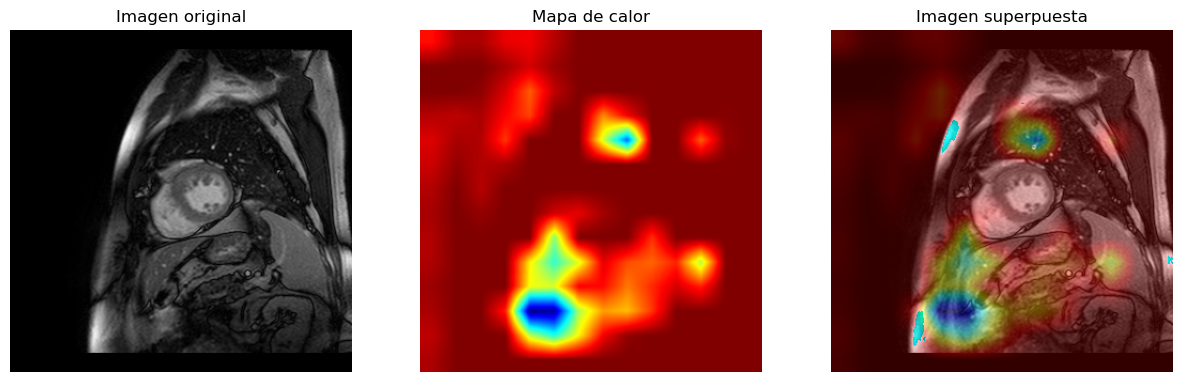

Procesando imagen 7...


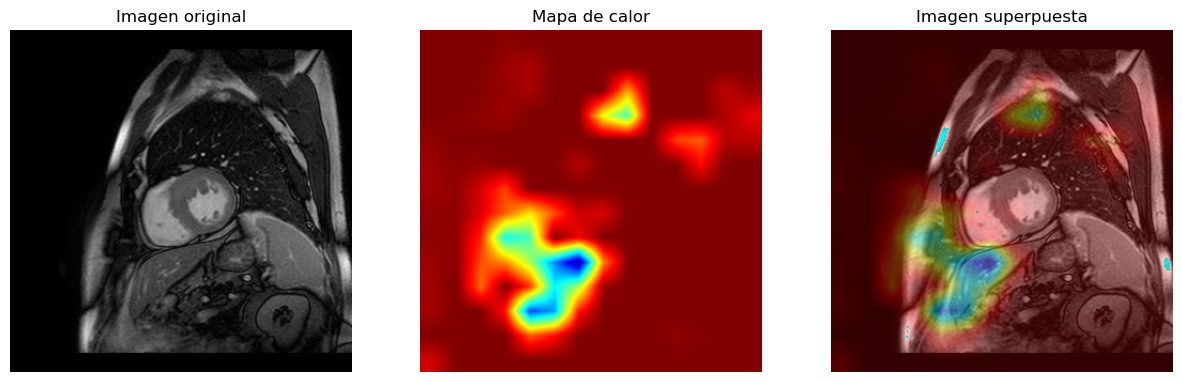

Procesando imagen 8...


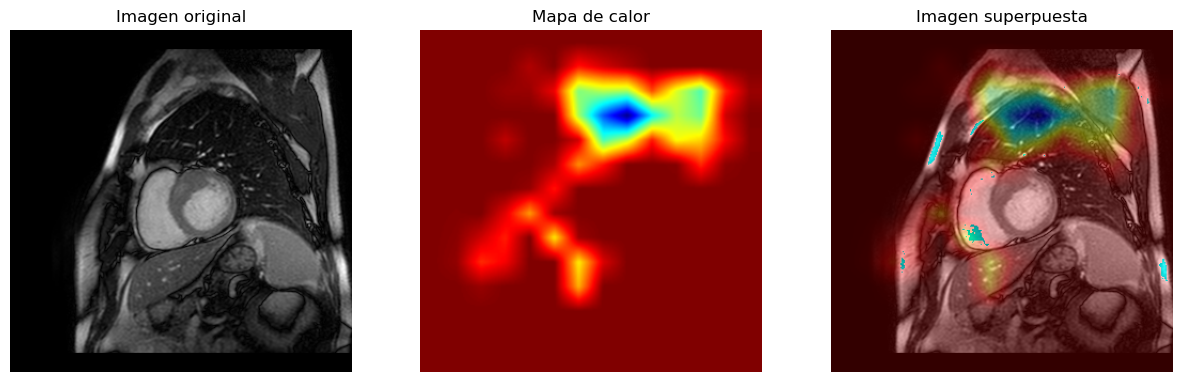

Procesando imagen 9...


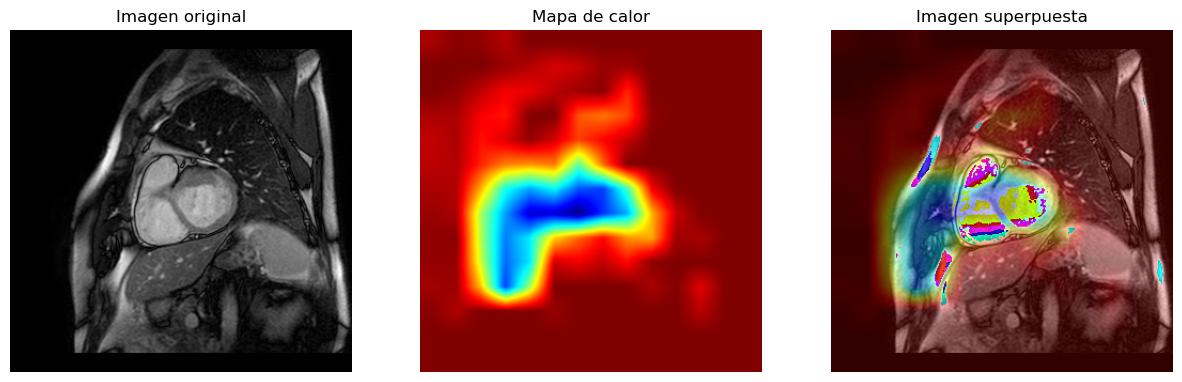

Procesando imagen 10...


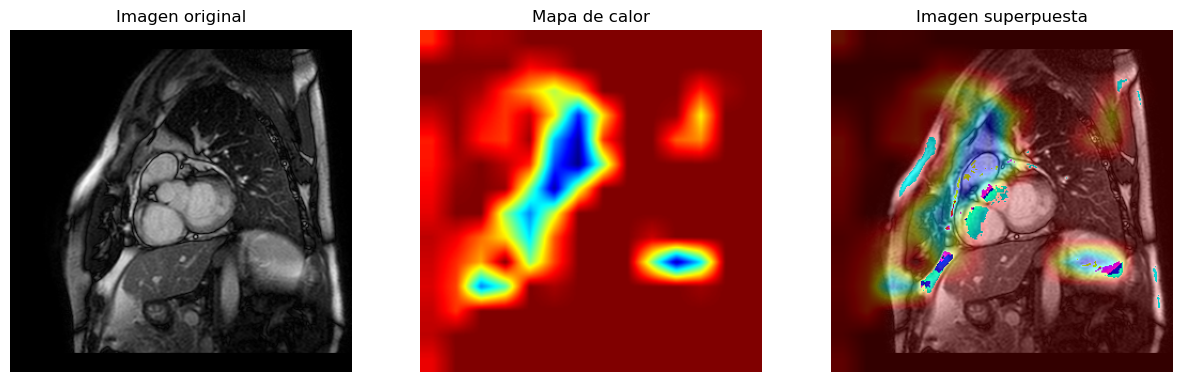

Procesando imagen 11...


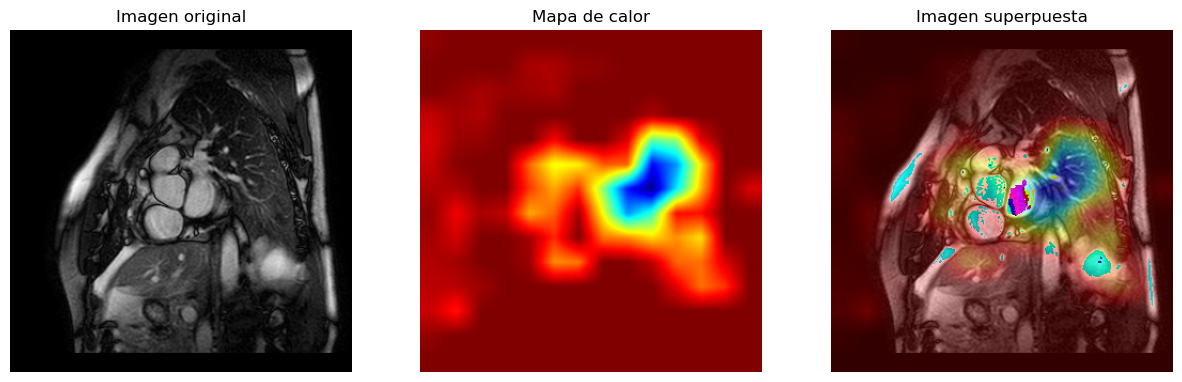

Procesando imagen 12...


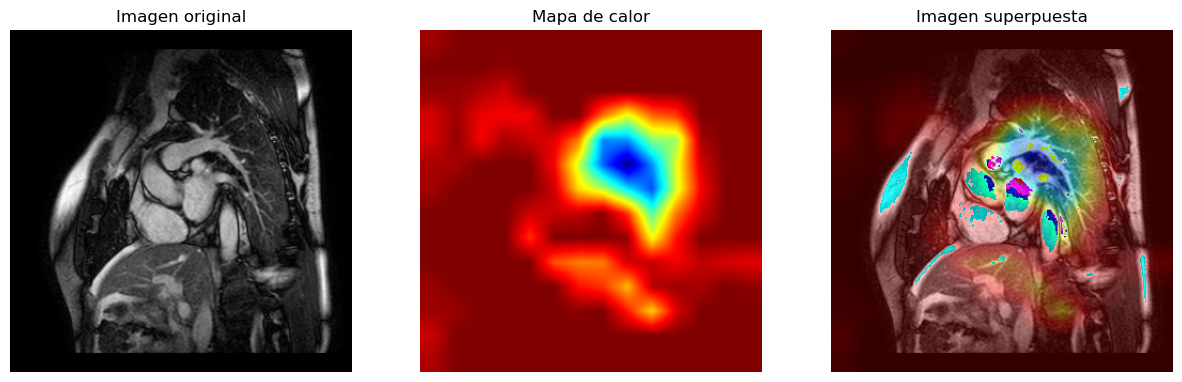

In [75]:
image_list = [
    r'D:\Feina\00_Test\MCH\_14\Mag (0024).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0048).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0072).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0096).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0120).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0144).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0168).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0192).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0216).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0240).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0264).png',
    r'D:\Feina\00_Test\MCH\_14\Mag (0288).png',
]

layer_name = 'block5_conv3'
for idx, image_path in enumerate(image_list):
    print(f"Procesando imagen {idx+1}...")
    grad_cam(model, image_path, layer_name)